# 특성 선택
* 여러 변환 과정을 거치다 보면 필요 이상으로 필요 없는 특성들이 추가적으로 생길 수도 있다.
* 원본 데이터 세트를 가지고 왔는데, 노이즈 데이터가 많을 수도 있다.
* 비즈니스 전문가가 없다면? 엔지니어가 직접 데이터를 **정제**해야 하는 일들이 생김
  * 어떠한 데이터가 좋은 데이터이고, 어떠한 데이터가 나쁜 데이터인가?


## 특성 자동 선택
* 일변량 통계 : Unvariable statistics
* 모델 기반 선택 : model-based Selection
* 반복적 선택 : Iterative Selection

# 일변량 통계
* 각각의 특성과 타깃 사이에 중요한 통계적 관계가 있는지를 계산한다.
* 깊게 연관되어 있는 특성을 선택한다.
* 분류에서는 **분산 분석**이라고 한다.
* 각 특성이 독립적으로 평가 - **일변량**
* 다른 특성과 깊게 연관된 특성은 선택이 안될 가능이 크다.

----
> 지지도 : 타깃이 특성을 얼마나 지지하는가에 대한 점수(p-값)

* SelectKBest - 지지도가 좋은 K개의 특성만 사용하기
* SelectPercentile - 지정된 비율만큼 특성을 선택


In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile

In [ ]:
import numpy as np
cancer = load_breast_cancer()

# 난수 발생
np.random.seed(42)
noise = np.random.randn(len(cancer['data']), 50)

cancer['data'].shape, noise.shape

((569, 30), (569, 50))

In [ ]:
# 정상 데이터 30개 + 노이즈 데이터 30개 합치기
X_w_noise = np.hstack([cancer['data'], noise])
X_w_noise.shape

(569, 80)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise,
    cancer['target'],
    random_state=0,
    test_size=.5
)

## 일변량 통계 사용하기

In [ ]:
select = SelectPercentile(percentile=50) # 50%의 데이터만 선택
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train)

print("X_train.shape : {}".format(X_train.shape))
print("X_train_selected.shape : {}".format(X_train_selected.shape))

X_train.shape : (284, 80)
X_train_selected.shape : (284, 40)


`get_support()` 함수를 활용하여 어떤 특성이 선택 되었는지 알 수 있다.

In [ ]:
mask = select.get_support()
print(mask)

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


In [ ]:
def selected_visualization(selected_mask):
  plt.matshow(selected_mask.reshape(1, -1), cmap='gray_r')
  plt.xlabel("Feature Number")
  plt.yticks([0])
  plt.show()

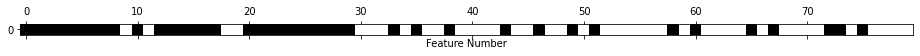

In [ ]:
selected_visualization(mask)

## LogisticRegression을 이용해서 테스트

In [ ]:
from sklearn.linear_model import LogisticRegression

# 테스트 세트 변환
X_test_selected = select.transform(X_test)

lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)
print("노이즈가 포함된 전체 특성을 사용했을 때 훈련 점수 : {:.3f}".format(lr.score(X_train, y_train)))
print("노이즈가 포함된 전체 특성을 사용했을 때 테스트 점수 : {:.3f}".format(lr.score(X_test, y_test)))

print()

lr = LogisticRegression(max_iter=100000).fit(X_train_selected, y_train)

print("노이즈가 제거된 일부 특성을 사용했을 때 훈련 점수 : {:.3f}".format(lr.score(X_train_selected, y_train)))
print("노이즈가 제거된 일부 특성을 사용했을 때 테스트 점수 : {:.3f}".format(lr.score(X_test_selected, y_test)))

노이즈가 포함된 전체 특성을 사용했을 때 훈련 점수 : 1.000
노이즈가 포함된 전체 특성을 사용했을 때 테스트 점수 : 0.951

노이즈가 제거된 일부 특성을 사용했을 때 훈련 점수 : 0.986
노이즈가 제거된 일부 특성을 사용했을 때 테스트 점수 : 0.933


# 모델 기반 특성 선택
* 지도학습 머신러닝 모델을 이용해서 **특성의 중요도를 평가**해서 가장 중요한 특성만 선택
* 특성 선택을 위해 사용하는 머신러닝 모델을 **최종적으로 사용할 지도학습 모델과 같을 필요는 없다.**
* 결정 트리 같은 트리 기반 알고리즘에는 `feature_importance`특성을 활용해 중요도를 판단할 수 있다.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold='median'# 절반만 쓰겠다.
)

select.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [ ]:
X_train_rf = select.transform(X_train)

print("X_train.shape : {}".format(X_train.shape))
print("X_train_rf.shape : {}".format(X_train_rf.shape))

X_train.shape : (284, 80)
X_train_rf.shape : (284, 40)


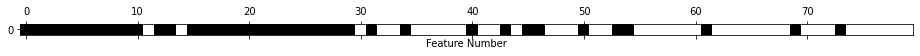

In [ ]:
mask = select.get_support()

selected_visualization(mask)

# 반복적 특성 선택
* 특성을 하나도 선택하지 않은 상태로 어떠한 종료 조건에 도달 할 때까지 특성을 하나씩 추가하는 기법
* 모든 특성을 가지고 시작하여 어떤 종료 조건에 도달 할 때까지 특성을 하나씩 제거하는 방법 **보통 사용되는 방법**
----
* 일단 모델이 만들어지고 시작을 하기 때문에 일변량 분석, 모델 기반 선택보다 계산 비용이 훨씬 많이 든다.
* **재귀적 특성 제거(Recursive Feature Elimination)** 일반적인 방법
  * 모든 특성을 사용해서 모델을 만들고, **특성중요도**가 가장 낮은 특성을 하나 제거
  * 제거 되지 않은 특성을 모두 사용해서 또 새로운 모델을 만들어서 테스트
  * 이 과정을 반복

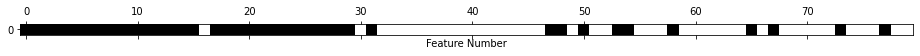

In [ ]:
from sklearn.feature_selection import RFE

select = RFE(
    RandomForestClassifier(n_estimators=100, random_state=42),
    n_features_to_select=40 # 종료 조건(선택된 feature가 40개가 될 때까지 재귀)
)

select.fit(X_train, y_train)

mask = select.get_support()
selected_visualization(mask)

특성 자동 선택 기법은 맹신하지 말자.